# Wasserstein GAN
[WGAN paper](https://arxiv.org/pdf/1704.00028.pdf).  
[DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf).  
[Implementation details](http://liftothers.org/dokuwiki/doku.php?id=cs501r_f2018:lab8).  

In [1]:
# !python3 -m pip install imageio

In [2]:
from datetime import datetime
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
from imageio import imread
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
from tqdm import tqdm

## Sample Images
Image shape is (218,178,3).  
202,599 images.

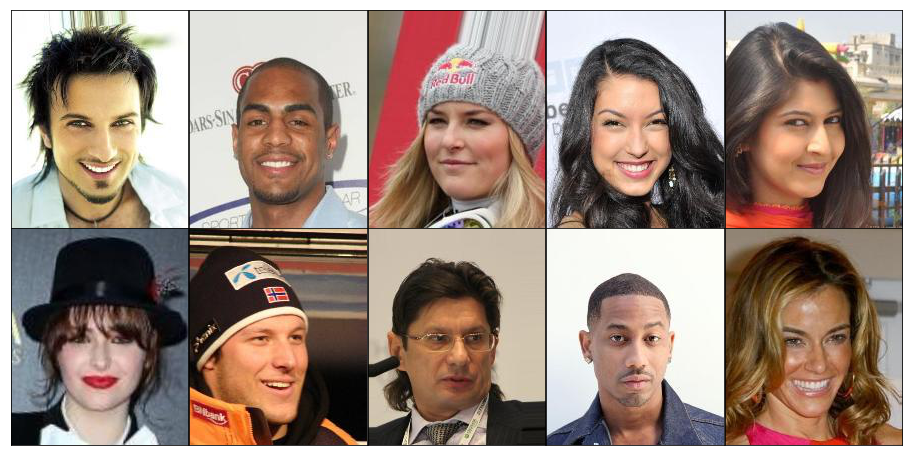

In [3]:
n_images = 202599
start = np.random.randint(1, n_images-20)
FOLDER = 'img_align_celeba/0/'
FILES = ["{}{:06}.jpg".format(FOLDER, i) for i in range(start+1, start+21)]

scale = 0.8
fig, axs = plt.subplots(2, 5, figsize=(scale*20,scale*10))
for i, ax in enumerate(axs.flatten()):
    img = imread(FILES[i])
    ax.imshow(imread(FILES[i]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

## DataLoader

In [4]:
def display_x_tensor(t, title=None):
    npimg = t.cpu().numpy().clip(0, 1)
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    if title:
        plt.title(title)
    plt.show()
    
def generate_z(n=1):
    return torch.tensor(np.random.uniform(low=-1, high=1, size=(n,100))).float()

class CelebDataset(Dataset):
    def __init__(self, folder='img_align_celeba/'):
        self.dataset_folder = datasets.ImageFolder(folder, transform=transforms.Compose([
            transforms.Resize((128,128)),
            transforms.ToTensor()
        ]))
            
    def __getitem__(self,index):
        """
        Returns:
            x (3, 512, 512) - float in [0,1).
            y (512, 512) - byte in {0,1}.
        """
        img = self.dataset_folder[index][0] # (3, 218, 178) torch.FloatTensor with values in [0, 1]
        return img

    def __len__(self):
        assert len(self.dataset_folder) == n_images, "Missing images mismatch. {} != {}".format(
            len(self.dataset_folder), n_images)
        return len(self.dataset_folder)
        
celeb_dataset = CelebDataset()
n_dataset = len(celeb_dataset)

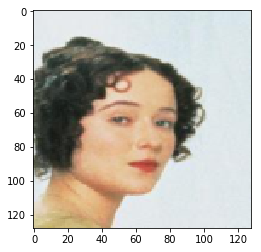

In [5]:
img = celeb_dataset[np.random.randint(n_dataset)]
display_x_tensor(img)

## Generator Overfitting Sanity Test

In [6]:
def generator_overfit(n_epochs=101, n_image_every=100, lr=0.001):
    gen = Generator()
    y_truth = celeb_dataset[0]
    z_const = generate_z(n=1)
    objective = nn.MSELoss()
    optimizer = optim.Adam(gen.parameters(), lr=lr)

    for i in range(n_epochs):
        z = torch.tensor(np.random.uniform(low=0, high=1, size=(100,)).astype(np.float32)).view(1,100)

        # Clear the gradients
        optimizer.zero_grad()

        # Generate an image
        y_hat = gen(z_const)

        # Calculate the loss and gradients
        loss = objective(y_truth, y_hat)
        loss.backward()

        optimizer.step()

        if i%n_image_every == 0:
            print("loss: {:.3f}, max: {:.3f}, min: {:.3f}".format(loss.item(), y_hat[0].max(), y_hat[0].min()))
            display_x_tensor(y_hat[0].detach())
            
# generator_overfit()

## Discriminator Overfitting Sanity Test

In [7]:
def discriminator_overfit(n_epochs=101, n_print_every=100, lr=0.001):
    dis = Discriminator()
    objective = nn.BCELoss()
    optimizer = optim.Adam(dis.parameters(), lr=lr)

    for i in range(n_epochs):
        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        x = celeb_dataset[0].unsqueeze(0)
    #     print(x.shape)
        label = torch.tensor(np.array([1])).float().view((1,1))
        y_hat = dis(x)

        # Calculate loss and gradients
    #     print("y_hat: {}, label: {}".format(y_hat.dtype, label.dtype))
    #     print("y_hat: {}, label: {}".format(y_hat.shape, label.shape))
#         loss = objective(y_hat, label)
        loss = y_hat
        loss.backward()

        # Update weights
        optimizer.step()

        # Print progress
        if i%n_print_every == 0:
            print("loss: {:.3f}, max: {:.3f}, min: {:.3f}".format(loss.item(), y_hat[0].max(), y_hat[0].min()))

        dis(x)
        
# discriminator_overfit()

## Generator
How is a transposed convolution of size 5 supposed to generate an even-sized output from an even-sized input?
![img](https://i.imgur.com/LJwJq88.png)

loss: 5240.674, max: 0.854, min: 0.150


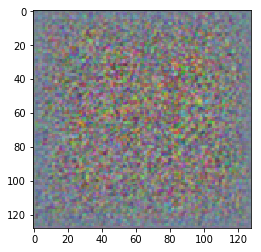

loss: 68.642, max: 0.989, min: 0.000


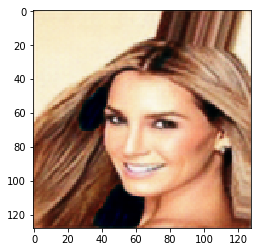

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        kernel_size_c = 3
        stride_c = 1
        padding_c = 1
        
        kernel_size = 4
        stride = 2
        padding = 1
        
        # starting size: (n, 100,)
        self.project = nn.Linear(100, 4*4*1024)
        
        # post_projection size: (n, 1024, 4, 4)
        # upsampled to (n, 1024, 8, 8)
        self.conv1 = nn.Sequential(
#             nn.Conv2d(1024, 512, kernel_size_c, stride_c, padding_c),
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, 
                               kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=512)
        )
        
        # post_conv1 size: (n, 512, 8, 8)
        self.conv2 = nn.Sequential(
#             nn.Conv2d(512, 256, kernel_size_c, stride_c, padding_c),
            nn.ConvTranspose2d(512, 256, kernel_size, stride, padding),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        
        # post_conv2 size: (256, 16, 16)
        self.conv3 = nn.Sequential(
#             nn.Conv2d(256, 128, kernel_size_c, stride_c, padding_c),
            nn.ConvTranspose2d(256, 128, kernel_size, stride, padding),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        
        # post_conv3 size: (128, 32, 32)
        self.conv4 = nn.Sequential(
#             nn.Conv2d(128, 64, kernel_size_c, stride_c, padding_c),
            nn.ConvTranspose2d(128, 64, kernel_size, stride, padding),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        
        # post_conv4 size: (64, 64, 64)
        # then upsample to remove checkerboard artifacts
        # size: (64, 128, 128)
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(64, 3, kernel_size_c, stride_c, padding_c),
#             nn.ConvTranspose2d(64, 3, kernel_size, stride, padding),
            nn.Sigmoid()
        )
        
        # post_conv5 size: (3, 128, 128)
    
    def forward(self, z):
        z1 = self.project(z).view(-1, 1024, 4, 4)
#         z1 = F.interpolate(z1, scale_factor=2)
        
        z2 = self.conv1(z1)
#         z2 = F.interpolate(z2, scale_factor=2)
        
        z3 = self.conv2(z2)
#         z3 = F.interpolate(z3, scale_factor=2)
        
        z4 = self.conv3(z3)
#         z4 = F.interpolate(z4, scale_factor=2)
        
        z5 = self.conv4(z4)
        z5 = F.interpolate(z5, scale_factor=2)
        
        z6 = self.conv5(z5)
        return z6
    
generator_overfit()

## Discriminator
![](https://i.imgur.com/OKHNAp0.png)

In [9]:
leaky_slope = 0.2

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        kernel_size = 4
        stride = 2
        padding = 1
        
        # input shape (n, 3, 128, 128)
        self.pre_conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size, stride, padding, bias=False),
            nn.LeakyReLU(leaky_slope),
            nn.BatchNorm2d(32)
        )
        
        # shape (n, 32, 64, 64)
        self.conv1 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size, stride, padding, bias=False),
            nn.LeakyReLU(leaky_slope),
            nn.BatchNorm2d(64)
        )
        
        # post_conv1 shape (n, 64, 32, 32)
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size, stride, padding, bias=False),
            nn.LeakyReLU(leaky_slope),
            nn.BatchNorm2d(128)
        )
        
        # post_conv2 shape (n, 128, 16, 16)
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size, stride, padding, bias=False),
            nn.LeakyReLU(leaky_slope),
            nn.BatchNorm2d(256)
        )
        
        # post_conv3 shape (n, 256, 8, 8)
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size, stride, padding, bias=False),
            nn.LeakyReLU(leaky_slope),
            nn.BatchNorm2d(512)
        )
        
        # post_conv4 shape (n, 512, 4, 4)
#         self.conv5 = nn.Sequential(
#             nn.Conv2d(512, 1, kernel_size=1, stride=1, padding=0, bias=False),
#             nn.LeakyReLU(leaky_slope)
#         )
        
        # post_conv5 shape (n, 1, 4, 4)
        self.dense = nn.Sequential(
            nn.Linear(512*4*4, 1) #, WGAN has no sigmoid, it's a critic and returns a score (the discriminator loss).
#             nn.Sigmoid()
        )
        
        # post_dense shape (n, 1)
    
    def forward(self, x):
        x1 = self.pre_conv1(x)
        x2 = self.conv1(x1)
        x3 = self.conv2(x2)
        x4 = self.conv3(x3)
        x5 = self.conv4(x4)
#         x6 = self.conv5(x5)
        out = self.dense(x5.view(-1, 512*4*4))
        return out
    
discriminator_overfit()

loss: -0.016, max: -0.016, min: -0.016
loss: -548.249, max: -548.249, min: -548.249


## Model Checkpointing
Save the model weights and a sample output image each epoch.  
This allows for resumption of training, results comparison, etc.

In [10]:
def model_checkpoint(CHECKPOINT_FOLDER='checkpoints/test/', epoch="?"):
    # Filenames
    FILE_FORMAT = '{time}_epoch{epoch}_{which}.weights'
    IMAGE_FORMAT = '{time}_epoch{epoch}_generated.jpg'
    INTERPOLATED_FORMAT = '{time}_epoch{epoch}_interpolated.jpg'
    strftime = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
    filename_gen = FILE_FORMAT.format(epoch=epoch, which='gen', time=strftime)
    filename_dis = FILE_FORMAT.format(epoch=epoch, which='dis', time=strftime)
    filename_img = IMAGE_FORMAT.format(epoch=epoch, time=strftime)
    filename_interpolated = INTERPOLATED_FORMAT.format(epoch=epoch, time=strftime)
    
    # Create necessary folder
    if not os.path.exists(CHECKPOINT_FOLDER):
        os.makedirs(CHECKPOINT_FOLDER)
        
    # More filenames
    GEN_PATH = CHECKPOINT_FOLDER+filename_gen
    DIS_PATH = CHECKPOINT_FOLDER+filename_dis
    IMG_PATH = CHECKPOINT_FOLDER+filename_img
    INTERPOLATED_PATH = CHECKPOINT_FOLDER + filename_interpolated
    CURRENT_GEN_PATH = CHECKPOINT_FOLDER + 'current_gen.weights'
    CURRENT_DIS_PATH = CHECKPOINT_FOLDER + 'current_dis.weights'
    CURRENT_IMG_PATH = CHECKPOINT_FOLDER + 'current_generated.jpg'
    CURRENT_INTERPOLATED_PATH = CHECKPOINT_FOLDER + 'current_interpolated.jpg'
    
    # Save the model weights
    torch.save(gen.state_dict(), GEN_PATH)
    torch.save(gen.state_dict(), CURRENT_GEN_PATH)
    torch.save(dis.state_dict(), DIS_PATH)
    torch.save(dis.state_dict(), CURRENT_DIS_PATH)
    
    # Save a 4x4 grid of generated images
    img_grid = gen(generate_z(n=16).cuda()).detach()
    save_image(img_grid, IMG_PATH, nrow=4)
    save_image(img_grid, CURRENT_IMG_PATH, nrow=4)
    
    # Interpolate at 8 points
    z1, z2 = generate_z(n=1), generate_z(n=1)
    epsilons = np.linspace(0, 1, 8)
    zs = [e*z1 + (1-e)*z2 for e in epsilons]
    z = torch.stack(zs, dim=0).squeeze(1)
    interpolation_img = gen(z.cuda()).detach()
    save_image(interpolation_img, INTERPOLATED_PATH)
    save_image(interpolation_img, CURRENT_INTERPOLATED_PATH)

## Training Loop
Create or reload the model.
Train, saving at specified checkpoints.
Save model outputs into a new folder each time.

In [11]:
# n_images % batch_size

In [15]:
gen = nn.DataParallel(Generator().cuda())
dis = nn.DataParallel(Discriminator().cuda())

if False:
    GEN_PATH = "checkpoints/GPv2-Oct27/2018-10-27_15:00:52_epoch4_gen.weights"
    DIS_PATH = "checkpoints/GPv2-Oct27/2018-10-27_15:00:52_epoch4_dis.weights"
    gen.load_state_dict(torch.load(GEN_PATH))
    dis.load_state_dict(torch.load(DIS_PATH))

Number of Batches Per Epoch: 1582/1582
#############
## Epoch 0 #
#############
Epoch 0, Batch 0
Grad_D: 3.069, Grad_G: 2.653
Loss_D: 0.249, Loss_G: 0.028, Loss_GP: 0.922, D(real): 0.155, D(fake): -0.094/0.028


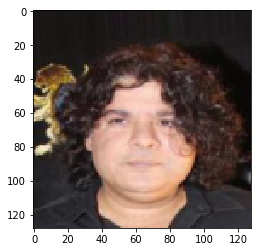

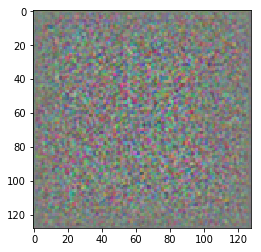

Epoch 0, Batch 1000
Grad_D: 7.970, Grad_G: 1.465
Loss_D: -1.941, Loss_G: -1.704, Loss_GP: 0.969, D(real): -4.534, D(fake): -2.593/-1.704


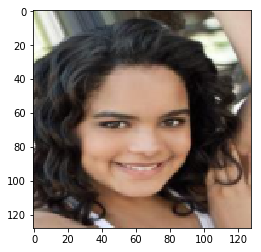

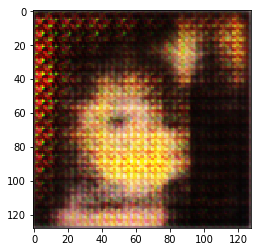

#############
## Epoch 1 #
#############
Epoch 1, Batch 0
Grad_D: 33.087, Grad_G: 2.160
Loss_D: -1.452, Loss_G: -10.270, Loss_GP: 0.898, D(real): -13.606, D(fake): -12.154/-10.270


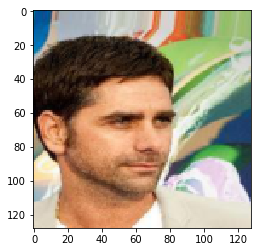

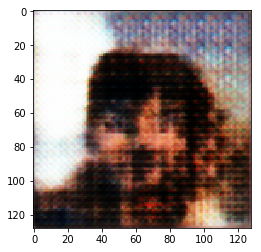

Epoch 1, Batch 1000
Grad_D: 101.601, Grad_G: 8.943
Loss_D: -16.857, Loss_G: 1.743, Loss_GP: 0.716, D(real): -21.519, D(fake): -4.662/1.743


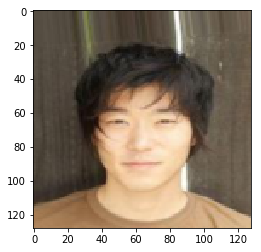

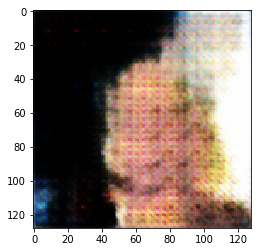

#############
## Epoch 2 #
#############
Epoch 2, Batch 0
Grad_D: 169.274, Grad_G: 10.877
Loss_D: -7.761, Loss_G: -4.553, Loss_GP: 0.497, D(real): -14.559, D(fake): -6.798/-4.553


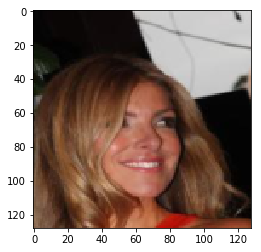

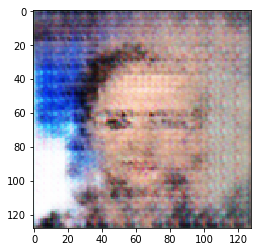

Epoch 2, Batch 1000
Grad_D: 304.909, Grad_G: 30.356
Loss_D: -74.101, Loss_G: 46.069, Loss_GP: 0.123, D(real): -37.000, D(fake): 37.101/46.069


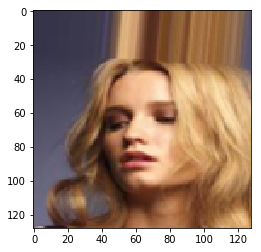

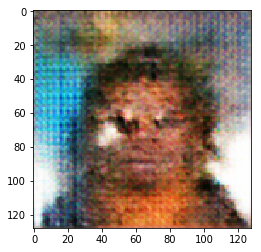

#############
## Epoch 3 #
#############
Epoch 3, Batch 0
Grad_D: 71.034, Grad_G: 5.486
Loss_D: 5.057, Loss_G: -104.731, Loss_GP: 0.699, D(real): -100.743, D(fake): -105.800/-104.731


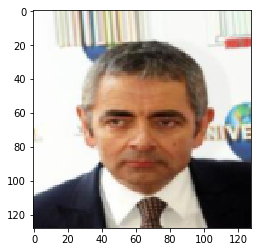

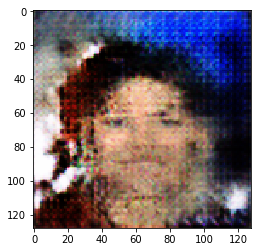

Epoch 3, Batch 1000
Grad_D: 693.873, Grad_G: 26.055
Loss_D: -46.272, Loss_G: 13.022, Loss_GP: 0.050, D(real): -31.561, D(fake): 14.711/13.022


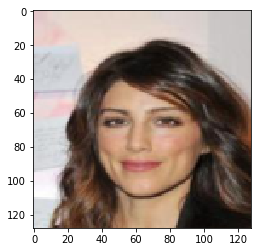

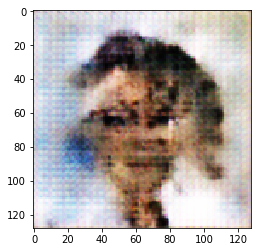

#############
## Epoch 4 #
#############
Epoch 4, Batch 0
Grad_D: 600.339, Grad_G: 42.285
Loss_D: -33.730, Loss_G: 33.120, Loss_GP: 0.092, D(real): -40.357, D(fake): -6.627/33.120


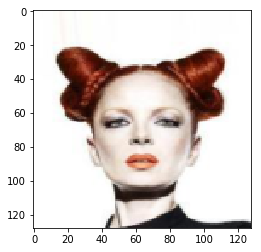

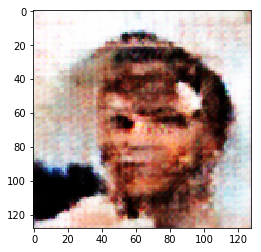

Epoch 4, Batch 1000
Grad_D: 1041.788, Grad_G: 71.657
Loss_D: -119.992, Loss_G: 0.838, Loss_GP: 0.958, D(real): -113.105, D(fake): 6.888/0.838


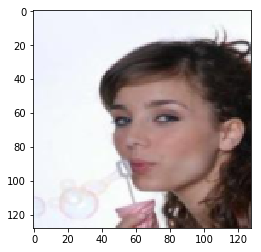

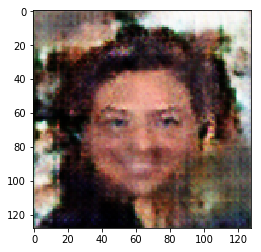

#############
## Epoch 5 #
#############
Epoch 5, Batch 0
Grad_D: 944.573, Grad_G: 33.178
Loss_D: -77.893, Loss_G: 44.583, Loss_GP: 1.605, D(real): -45.789, D(fake): 32.103/44.583


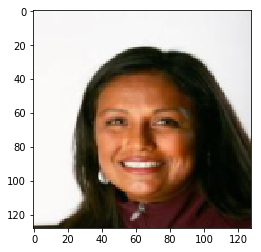

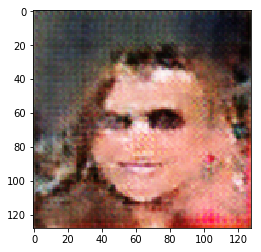

Epoch 5, Batch 1000
Grad_D: 1561.590, Grad_G: 64.153
Loss_D: -109.745, Loss_G: 30.473, Loss_GP: 3.996, D(real): -93.262, D(fake): 16.483/30.473


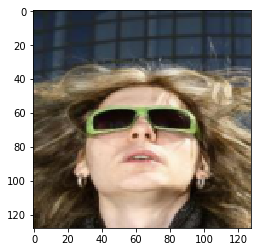

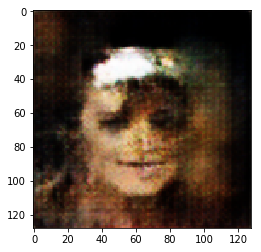

#############
## Epoch 6 #
#############
Epoch 6, Batch 0
Grad_D: 1716.598, Grad_G: 63.715
Loss_D: -47.931, Loss_G: 60.723, Loss_GP: 1.818, D(real): -8.244, D(fake): 39.686/60.723


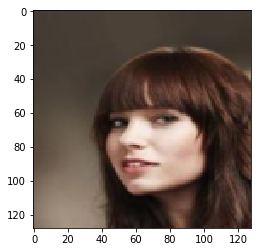

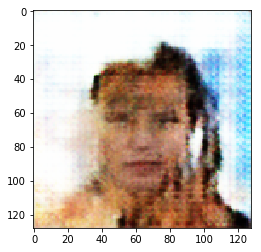

Epoch 6, Batch 1000
Grad_D: 1969.998, Grad_G: 82.863
Loss_D: -158.673, Loss_G: 70.243, Loss_GP: 5.137, D(real): -148.001, D(fake): 10.673/70.243


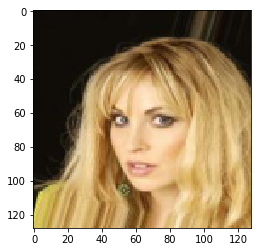

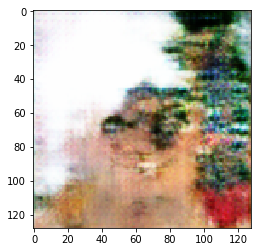

#############
## Epoch 7 #
#############
Epoch 7, Batch 0
Grad_D: 1664.770, Grad_G: 42.573
Loss_D: -28.480, Loss_G: -205.476, Loss_GP: 2.224, D(real): -227.424, D(fake): -198.944/-205.476


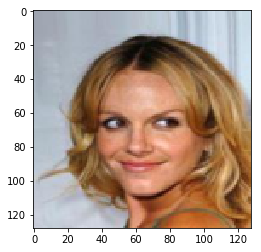

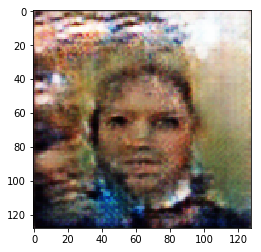

Epoch 7, Batch 1000
Grad_D: 3372.431, Grad_G: 109.302
Loss_D: -194.877, Loss_G: 72.284, Loss_GP: 11.706, D(real): -136.345, D(fake): 58.532/72.284


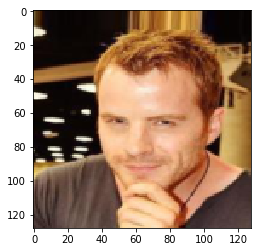

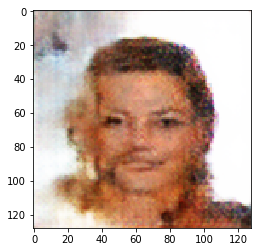

#############
## Epoch 8 #
#############
Epoch 8, Batch 0
Grad_D: 2416.970, Grad_G: 117.010
Loss_D: -171.572, Loss_G: 50.822, Loss_GP: 13.481, D(real): -145.900, D(fake): 25.672/50.822


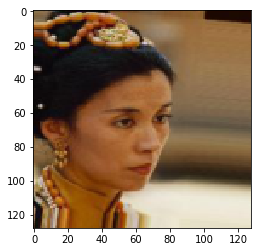

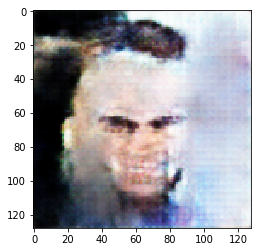

Epoch 8, Batch 1000
Grad_D: 1924.948, Grad_G: 123.615
Loss_D: -162.534, Loss_G: 53.373, Loss_GP: 14.603, D(real): -232.001, D(fake): -69.467/53.373


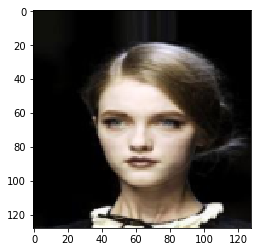

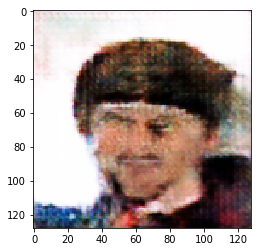

#############
## Epoch 9 #
#############
Epoch 9, Batch 0
Grad_D: 3249.012, Grad_G: 126.912
Loss_D: -204.426, Loss_G: 181.941, Loss_GP: 30.942, D(real): -48.225, D(fake): 156.201/181.941


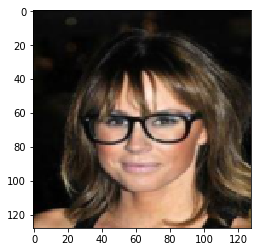

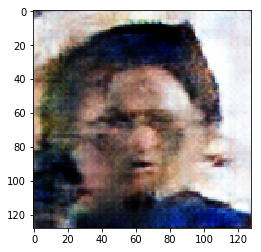

Epoch 9, Batch 1000
Grad_D: 5924.981, Grad_G: 319.411
Loss_D: -137.383, Loss_G: 107.401, Loss_GP: 23.879, D(real): -43.765, D(fake): 93.618/107.401


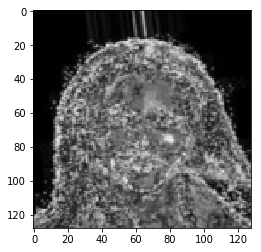

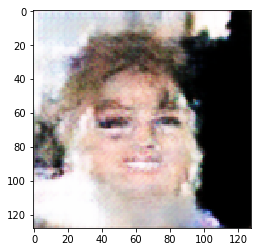

#############
## Epoch 10 #
#############
Epoch 10, Batch 0
Grad_D: 3020.997, Grad_G: 243.493
Loss_D: 48.855, Loss_G: 401.003, Loss_GP: 30.219, D(real): 318.340, D(fake): 269.485/401.003


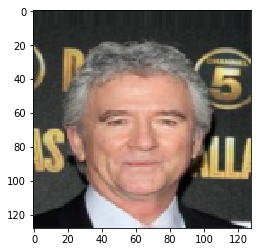

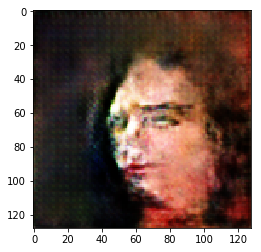

Epoch 10, Batch 1000
Grad_D: 4070.411, Grad_G: 147.237
Loss_D: -541.843, Loss_G: 345.467, Loss_GP: 47.191, D(real): -248.597, D(fake): 293.246/345.467


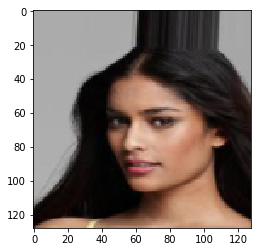

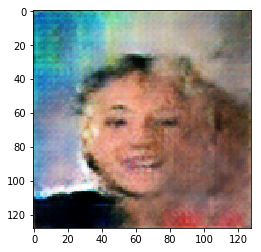

#############
## Epoch 11 #
#############
Epoch 11, Batch 0
Grad_D: 4435.059, Grad_G: 178.351
Loss_D: -268.861, Loss_G: 132.701, Loss_GP: 51.328, D(real): -391.935, D(fake): -123.074/132.701


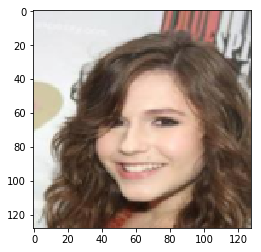

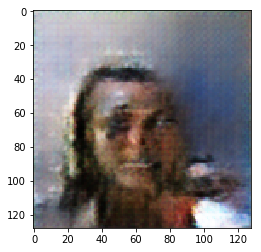

Epoch 11, Batch 1000
Grad_D: 8220.397, Grad_G: 342.314
Loss_D: -273.679, Loss_G: 119.881, Loss_GP: 75.606, D(real): 79.189, D(fake): 352.868/119.881


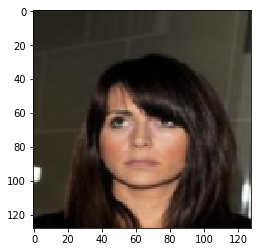

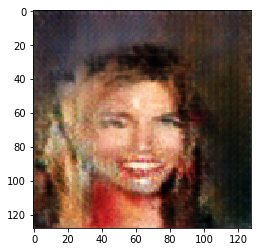

#############
## Epoch 12 #
#############
Epoch 12, Batch 0
Grad_D: 6863.969, Grad_G: 736.915
Loss_D: -442.259, Loss_G: 136.653, Loss_GP: 93.315, D(real): -170.594, D(fake): 271.666/136.653


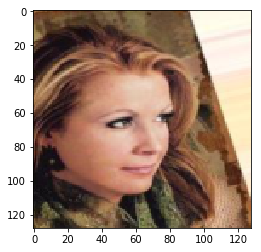

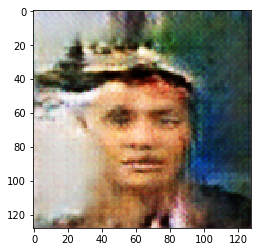

Epoch 12, Batch 1000
Grad_D: 3072.737, Grad_G: 479.127
Loss_D: -641.554, Loss_G: 539.411, Loss_GP: 29.406, D(real): -247.829, D(fake): 393.725/539.411


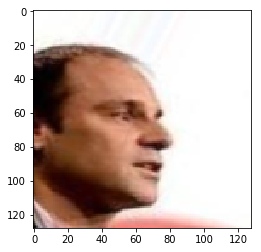

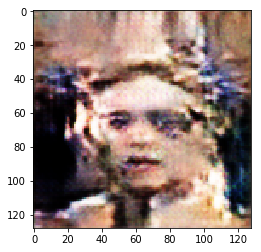

#############
## Epoch 13 #
#############
Epoch 13, Batch 0
Grad_D: 2279.751, Grad_G: 151.931
Loss_D: -91.415, Loss_G: -738.124, Loss_GP: 2.618, D(real): -858.503, D(fake): -767.088/-738.124


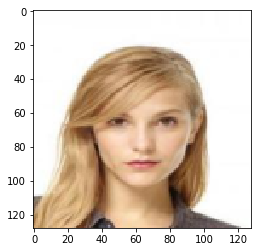

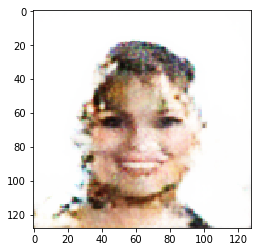

Epoch 13, Batch 1000
Grad_D: 5147.914, Grad_G: 416.464
Loss_D: -653.059, Loss_G: 238.903, Loss_GP: 56.075, D(real): -336.193, D(fake): 316.866/238.903


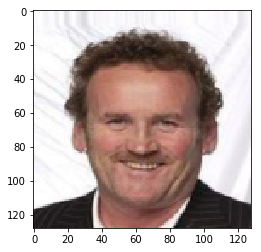

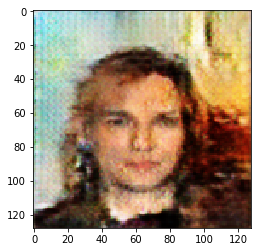

#############
## Epoch 14 #
#############
Epoch 14, Batch 0
Grad_D: 5703.338, Grad_G: 271.003
Loss_D: -252.010, Loss_G: 244.127, Loss_GP: 68.795, D(real): -95.501, D(fake): 156.509/244.127


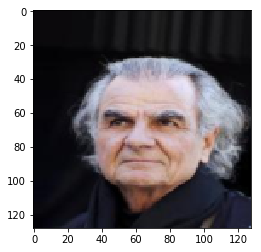

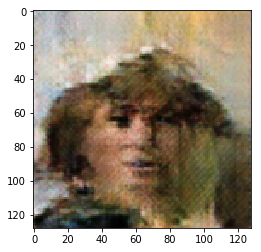

Epoch 14, Batch 1000
Grad_D: 4594.786, Grad_G: 481.880
Loss_D: 84.348, Loss_G: 305.514, Loss_GP: 34.194, D(real): 364.370, D(fake): 280.023/305.514


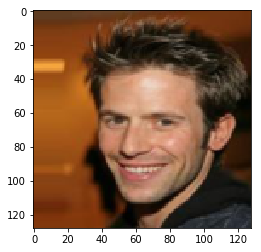

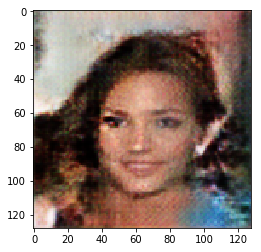

#############
## Epoch 15 #
#############
Epoch 15, Batch 0
Grad_D: 7887.776, Grad_G: 585.067
Loss_D: -495.875, Loss_G: -78.083, Loss_GP: 100.300, D(real): -282.628, D(fake): 213.246/-78.083


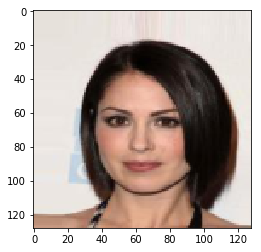

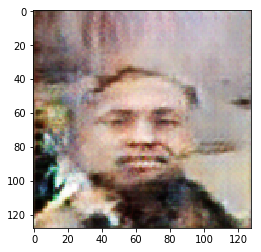

Epoch 15, Batch 1000
Grad_D: 9053.388, Grad_G: 371.046
Loss_D: -117.219, Loss_G: 201.125, Loss_GP: 91.155, D(real): -155.177, D(fake): -37.958/201.125


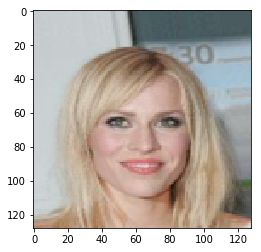

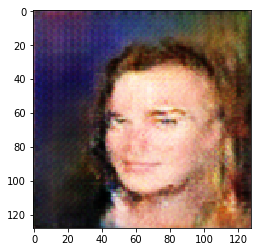

#############
## Epoch 16 #
#############
Epoch 16, Batch 0
Grad_D: 6972.039, Grad_G: 438.324
Loss_D: -824.922, Loss_G: 330.630, Loss_GP: 55.447, D(real): -676.343, D(fake): 148.578/330.630


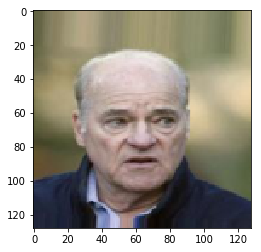

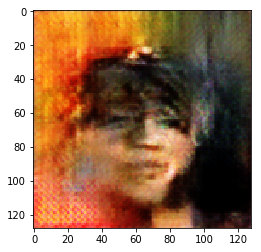

Epoch 16, Batch 1000
Grad_D: 14403.535, Grad_G: 544.826
Loss_D: -679.658, Loss_G: 470.667, Loss_GP: 134.960, D(real): 105.474, D(fake): 785.133/470.667


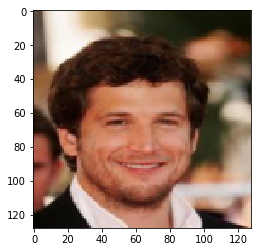

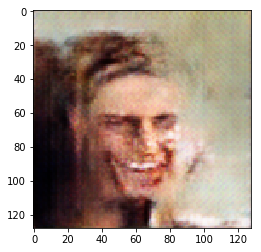

#############
## Epoch 17 #
#############
Epoch 17, Batch 0
Grad_D: 7503.039, Grad_G: 318.499
Loss_D: -507.272, Loss_G: 419.760, Loss_GP: 77.096, D(real): -292.528, D(fake): 214.744/419.760


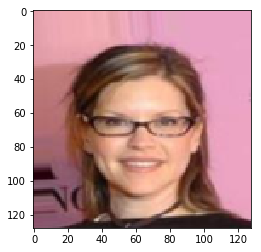

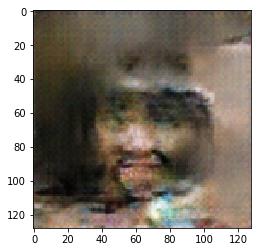

Epoch 17, Batch 1000
Grad_D: 9970.214, Grad_G: 860.009
Loss_D: -1120.688, Loss_G: 242.638, Loss_GP: 127.245, D(real): -574.034, D(fake): 546.654/242.638


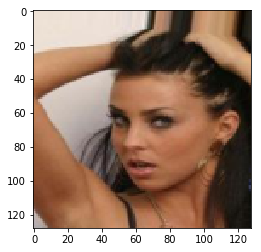

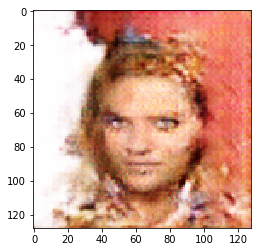

#############
## Epoch 18 #
#############
Epoch 18, Batch 0
Grad_D: 15795.800, Grad_G: 1420.162
Loss_D: -1104.282, Loss_G: 180.733, Loss_GP: 85.710, D(real): -187.813, D(fake): 916.469/180.733


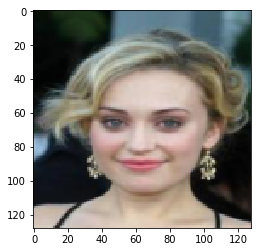

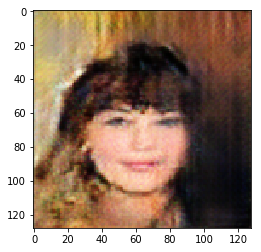

Epoch 18, Batch 1000
Grad_D: 14833.248, Grad_G: 705.250
Loss_D: -854.606, Loss_G: 573.445, Loss_GP: 140.189, D(real): -276.835, D(fake): 577.771/573.445


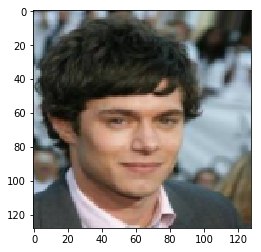

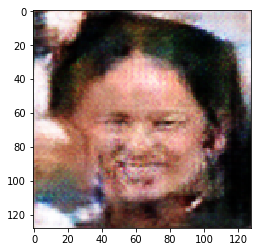

#############
## Epoch 19 #
#############
Epoch 19, Batch 0
Grad_D: 9087.111, Grad_G: 777.528
Loss_D: -403.440, Loss_G: -324.550, Loss_GP: 113.877, D(real): -439.700, D(fake): -36.261/-324.550


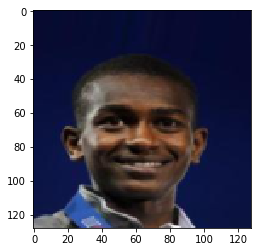

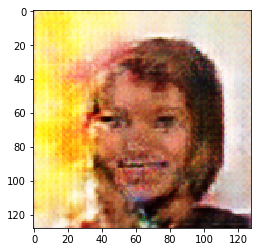

Epoch 19, Batch 1000
Grad_D: 11274.364, Grad_G: 457.210
Loss_D: -602.216, Loss_G: 337.367, Loss_GP: 130.825, D(real): -115.247, D(fake): 486.970/337.367


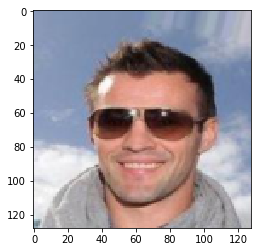

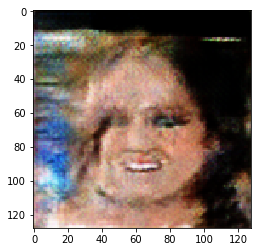

#############
## Epoch 20 #
#############
Epoch 20, Batch 0
Grad_D: 7472.471, Grad_G: 464.744
Loss_D: -235.588, Loss_G: 1112.550, Loss_GP: 132.103, D(real): 672.864, D(fake): 908.452/1112.550


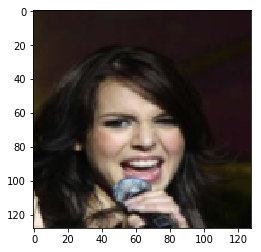

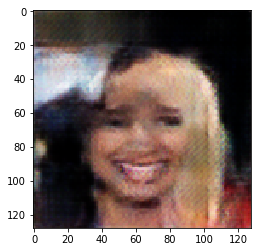

Epoch 20, Batch 1000
Grad_D: 8475.690, Grad_G: 303.496
Loss_D: -764.511, Loss_G: 1032.311, Loss_GP: 90.685, D(real): 27.148, D(fake): 791.659/1032.311


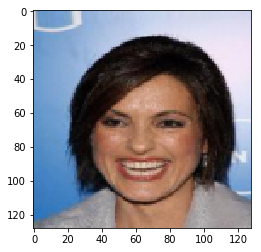

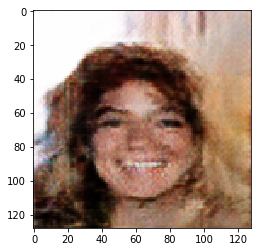

#############
## Epoch 21 #
#############
Epoch 21, Batch 0
Grad_D: 12787.312, Grad_G: 405.841
Loss_D: -869.358, Loss_G: 620.195, Loss_GP: 141.705, D(real): -672.651, D(fake): 196.707/620.196


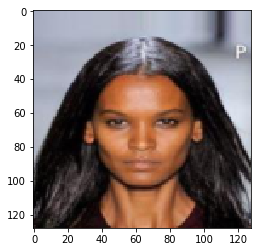

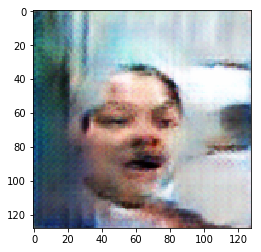

Epoch 21, Batch 1000
Grad_D: 13540.258, Grad_G: 1116.318
Loss_D: -636.469, Loss_G: 146.235, Loss_GP: 173.103, D(real): -570.879, D(fake): 65.590/146.235


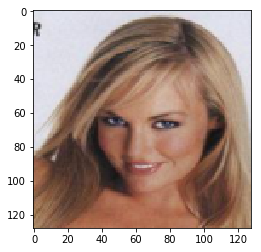

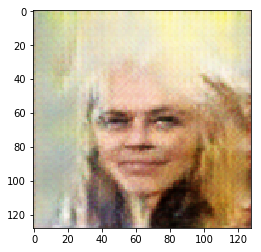

#############
## Epoch 22 #
#############
Epoch 22, Batch 0
Grad_D: 11568.533, Grad_G: 372.545
Loss_D: -739.319, Loss_G: 1125.576, Loss_GP: 111.470, D(real): 438.599, D(fake): 1177.918/1125.576


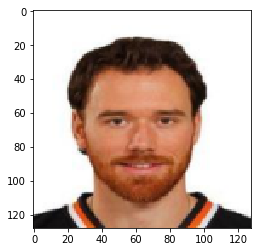

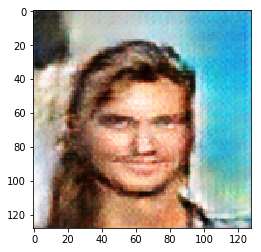

Epoch 22, Batch 1000
Grad_D: 20224.754, Grad_G: 902.695
Loss_D: -1155.471, Loss_G: -227.313, Loss_GP: 172.824, D(real): -607.097, D(fake): 548.373/-227.313


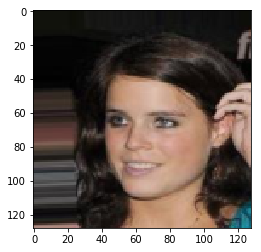

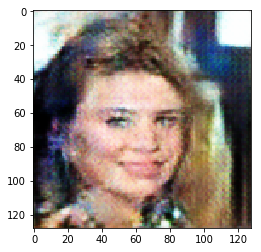

#############
## Epoch 23 #
#############
Epoch 23, Batch 0
Grad_D: 24518.656, Grad_G: 517.413
Loss_D: -1122.818, Loss_G: 1017.610, Loss_GP: 232.573, D(real): -76.741, D(fake): 1046.077/1017.610


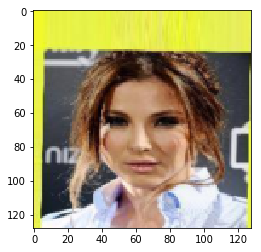

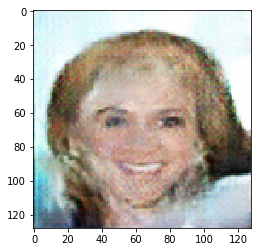

Epoch 23, Batch 1000
Grad_D: 16209.878, Grad_G: 855.607
Loss_D: -1519.043, Loss_G: 860.876, Loss_GP: 166.651, D(real): -150.384, D(fake): 1368.658/860.877


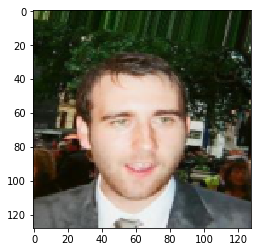

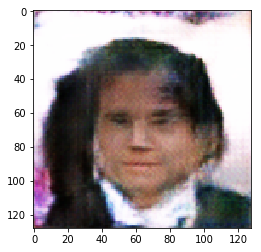

#############
## Epoch 24 #
#############
Epoch 24, Batch 0
Grad_D: 20015.438, Grad_G: 1923.208
Loss_D: -1630.026, Loss_G: 762.923, Loss_GP: 371.782, D(real): 26.258, D(fake): 1656.283/762.923


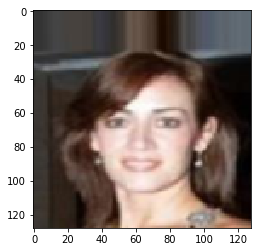

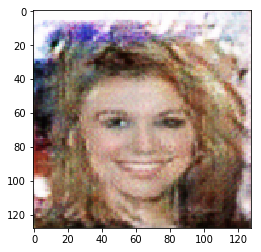

Epoch 24, Batch 1000
Grad_D: 21944.407, Grad_G: 977.943
Loss_D: -1413.885, Loss_G: 183.315, Loss_GP: 176.696, D(real): -699.861, D(fake): 714.024/183.315


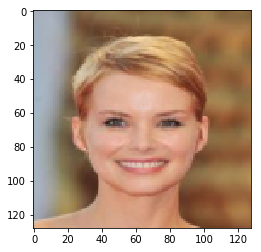

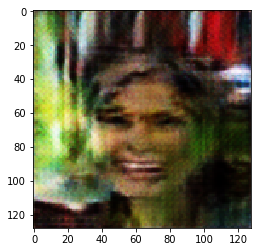

done


In [16]:
CHECKPOINT_FOLDER = 'checkpoints/Oct30-128px-iter3-twogpus/'
batch_size = 128
n_batches = n_images // batch_size # 3125
n_epochs = 25
n_batches_per_epoch = n_batches
n_image_every = 1000
n_critic = 5
lr_gen = 0.001
lr_dis = 0.00001 # or 0.00001
beta1 = 0.5 # Adam momentum term
lmbda = 10 # gradient penalty term
c = 0.05 # discriminator weight clamping
# objective = nn.BCELoss()
objective = lambda y_true, y_pred: (y_true * y_pred).mean()
optimizer_gen = optim.Adam(gen.parameters(), lr=lr_gen, betas=(beta1, 0.999))
optimizer_dis = optim.Adam(dis.parameters(), lr=lr_dis, betas=(beta1, 0.999))

# Since our loss is label*score, this trains our model to give real images a negative score
# and fake images a positive score. It probably makes more sense to give real images a positive score,
# but we'll shelve that for now. https://github.com/keras-team/keras-contrib/issues/280
real_label = 1
fake_label = -1

celeb_loader = DataLoader(
    dataset=celeb_dataset,
    batch_size=batch_size,
    pin_memory=True, 
    shuffle=True
)


print("Number of Batches Per Epoch: {}/{}".format(n_batches_per_epoch, n_batches))
for i_epoch in range(n_epochs):
    print("#############")
    print("## Epoch {} #".format(i_epoch))
    print("#############")
    # Save intermediate progress
    model_checkpoint(CHECKPOINT_FOLDER, i_epoch)
    # Train
    for i_batch, x_truth in enumerate(celeb_loader):
        x_truth = x_truth.cuda(non_blocking=True)
        batch_size_actual = x_truth.shape[0]
        ####################
        # Update D network #
        ####################
        dis.zero_grad()

        # train with real
        label = torch.full((batch_size,), real_label).cuda()
        output = dis(x_truth)
        err_dis_real = objective(output, label)
        err_dis_real.backward()
        D_x = output.mean().item()

        # train with fake
        z = generate_z(n=batch_size_actual)
        x_fake = gen(z.cuda(non_blocking=True))
        label.fill_(fake_label)
        output = dis(x_fake.detach())
        err_dis_fake = objective(output, label)
        err_dis_fake.backward()
        D_xfake_1 = output.mean().item()
        err_dis = err_dis_real + err_dis_fake
        optimizer_dis.step()
#         for p in dis.parameters():
#             p.data.clamp_(-c, c)
            
        # gradient penalty
        # see https://discuss.pytorch.org/t/gradient-penalty-with-respect-to-the-network-parameters/11944/2
        epsilon = np.random.uniform(0, 1)
        x_middle = (epsilon*x_truth + (1-epsilon)*x_fake)
        output = dis(x_middle.cuda(non_blocking=True)).mean()
        grad_wrt_x = torch.autograd.grad(output, x_middle, create_graph=True)[0]
        loss_gp = ((grad_wrt_x.view(batch_size_actual, -1).norm(dim=1) - 1)**2).mean()
        loss_gp.backward()
        err_gp = loss_gp.item()
        optimizer_dis.step()        
        
        if i_batch % n_critic == 0:
            ####################
            # Update G network #
            ####################
            gen.zero_grad()

            z = generate_z(n=batch_size)
            x_fake = gen(z.cuda())
            label.fill_(real_label) # reverse the discriminator
            output = dis(x_fake)
            # Generator seeks negative loss
            # minimize either log(1-D(G(z))) or -log(D(G(z))) (larger gradients earlier in training).
            err_gen = objective(output, label) 
            err_gen.backward()
            # Generator seeks negative output (meaning it's viewed as real)
            D_xfake_2 = output.mean().item()
            optimizer_gen.step()
        
        # Display intermediate progress
        if i_batch % n_image_every == 0:
            grad_gen_norm = np.mean([param.grad.norm().item() for param in gen.parameters()])
            grad_dis_norm = np.mean([param.grad.norm().item() for param in dis.parameters()])
            print("Epoch {}, Batch {}".format(i_epoch, i_batch))
            print("Grad_D: {:.3f}, Grad_G: {:.3f}".format(grad_dis_norm, grad_gen_norm))
            print("Loss_D: {:.3f}, Loss_G: {:.3f}, Loss_GP: {:.3f}, D(real): {:.3f}, D(fake): {:.3f}/{:.3f}".format(
                err_dis, err_gen, err_gp, D_x, D_xfake_1, D_xfake_2
            ))
            display_x_tensor(x_truth[0].detach())
            display_x_tensor(x_fake[0].detach())
            
            
        if i_batch == n_batches_per_epoch:
            break
                
        
print("done")
model_checkpoint(CHECKPOINT_FOLDER, i_epoch)

In [ ]:
model_checkpoint()

## Sample Generated Images

<img src="https://i.imgur.com/6hbsjxA.jpg" alt="Drawing" style="height: 600px;"/>

## Interpolation in Latent Space

<img src="https://i.imgur.com/ramy3id.jpg" alt="Drawing" style="height:150px;"/>

## Notes
Discriminator gradient penalty only works if we remove batch-norm.  
Discriminator is terrible if we remove batch-norm, allowing stark pixelated adversarial examples.  
Checkerboard pattern in generated images is caused by overlap in transposed convolutions (fx kernel size 4, stride 2). See [this explanation](https://distill.pub/2016/deconv-checkerboard/). Upsample with a stride-1 deconvolution in the final generator layer.  
Generator batch-norm makes it less prone to catastrophic forgetting/discriminator exploitation. Including gen-BN makes its initial image generation pixelated, as opposed to a flat gray. Omitting gen-BN makes its images oscillate from white to black, overfitting wildly.